In [492]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn import svm, linear_model, cluster, mixture

In [534]:
data = pd.read_csv("weather_data/weather_prediction_dataset.csv")
towns = {col.split("_")[0] for col in data.columns[2:]}
m = [min([i if c.lower() == c else 10 for i, c in enumerate(col.split("_"))]) for col in data.columns]
towns = {"_".join(col.split("_")[:m[i]]) for i, col in enumerate(data.columns)}
towns.remove("DATE")
towns.remove("MONTH")
labels = pd.read_csv("weather_data/weather_prediction_picnic_labels.csv").replace({True: 1, False: 0})
data = data.join(labels.set_index("DATE"), on="DATE")

In [535]:
all_combined = None
town_data = {}
cols = {}
full_towns = set()
print(f"{'TOWN':10} is full")
for t in towns:
    temp = data.loc[:, data.columns.str.startswith(t)]
    temp.columns = [col.strip(t+"_") for col in temp.columns]
    town_data[t] = temp
    if len(temp.columns) == 12:
        full_towns.add(t)
        print(f"{t:12} YES")
        print(temp.columns)
        print()
        if all_combined is None:
            all_combined = temp
            cols = temp.columns
        else:
            all_combined = pd.concat([all_combined, temp])
            cols = cols.intersection(temp.columns)
    else:
        print(f"{t:12} NO")
        print(temp.columns)
        print()
all_full_combined = all_combined.reset_index().drop("index", axis=1)

TOWN       is full
DE_BILT      YES
Index(['cloud_cover', 'wind_speed', 'wind_gust', 'humidity', 'pressure',
       'global_radiation', 'precipitation', 'sunshine', 'temp_mean',
       'temp_min', 'temp_max', 'picnic_weather'],
      dtype='object')

TOURS        NO
Index(['wind_speed', 'humidity', 'pressure', 'global_radiation',
       'precipitation', 'temp_mean', 'temp_min', 'temp_max', 'picnic_weather'],
      dtype='object')

LJUBLJANA    NO
Index(['cloud_cover', 'wind_speed', 'humidity', 'pressure', 'global_radiation',
       'precipitation', 'sunshine', 'temp_mean', 'temp_min', 'temp_max',
       'picnic_weather'],
      dtype='object')

MAASTRICHT   YES
Index(['cloud_cover', 'wind_speed', 'wind_gust', 'humidity', 'pressure',
       'global_radiation', 'precipitation', 'sunshine', 'temp_mean',
       'temp_min', 'temp_max', 'picnic_weather'],
      dtype='object')

MUENCHEN     YES
Index(['cloud_cover', 'wind_speed', 'wind_gust', 'humidity', 'pressure',
       'global_radiation'

In [287]:
def get_town_data(data_split, town, seed):
    # Load and shuffle
    tow = town_data[town]
    tow = shuffle(tow,random_state=seed)
    
    n = tow.shape[0]
    k = sum(data_split)
    train_stop = int(n*data_split[0]/k)
    test_stop = train_stop+int(n*data_split[1]/k)
    
    # Split data and label
    data = tow.loc[:, tow.columns[:-1]]
    labels = tow.loc[:, tow.columns[-1]]

    # Split train and test
    train_data = data.iloc[:train_stop, :]
    test_data = data.iloc[train_stop:test_stop, :]
    valid_data = data.iloc[test_stop:, :]
    train_labels = labels.iloc[:train_stop]
    test_labels = labels.iloc[train_stop:test_stop]
    valid_labels = labels.iloc[test_stop:]

    # Normalize
    means = train_data.mean(axis=0)
    var = train_data.var(axis=0)
    train_data = (train_data-means)/(var**0.5)
    test_data = (test_data-means)/(var**0.5)
    valid_data = (valid_data-means)/(var**0.5)

    return train_data, train_labels, test_data, test_labels, valid_data, valid_labels, means, var

In [176]:
def get_multiple_town_data(train_size, towns, seed, testing):
    # Load and shuffle
    tow = None
    for  t in towns:
        temp = town_data[t]
        if tow is None:
            tow = temp
        else:
            tow = pd.concat([tow, temp])
            
    tow = shuffle(tow,random_state=seed)
    
    # Split data and label
    data = tow.loc[:, tow.columns[:-1]]
    labels = tow.loc[:, tow.columns[-1]]

    if testing:
        # Split train and test
        train_data = data.iloc[:train_size, :]
        test_data = data.iloc[train_size:, :]
        train_labels = labels.iloc[:train_size]
        test_labels = labels.iloc[train_size:]

        # Normalize
        means = train_data.mean(axis=0)
        var = train_data.var(axis=0)
        train_data = (train_data-means)/(var**0.5)
        test_data = (test_data-means)/(var**0.5)

        return train_data, train_labels, test_data, test_labels, means, var
    else:
        # Normalize
        means = data.mean(axis=0)
        var = data.var(axis=0)
        data = (data-means)/(var**0.5)

        return data, labels, means, var

BASEL test

In [286]:
va_l

0

In [336]:
# BASEL:
#tr_d, tr_l, te_d, te_l, va_d, va_l, m, v = get_town_data([8,1,1], "BASEL", 42)

# STOCKHOLM:
#tr_d, tr_l, te_d, te_l, va_d, va_l, m, v = get_town_data([8,1,1], "STOCKHOLM", 42) 

# KASSEL:
tr_d, tr_l, te_d, te_l, va_d, va_l, m, v = get_town_data([8,1,1], "KASSEL", 42) 

In [337]:
val = 11
step = 4
way = 1
best_score = 0
best_val = val
tested = False

while step > 0.02:
    svc = svm.SVC(C=val, kernel='rbf', random_state=42)
    svc.fit(tr_d, tr_l)
    cross_score = np.mean(cross_val_score(svc, te_d, te_l, cv=5))
    if cross_score > best_score:
        best_score = cross_score
        best_val = val 
        tested = False
    elif not tested:
        way *= -1
        #step /= 2
        tested = True
    else:
        step /= 2
        tested = False
    #print(val, cross_score)
    val += step*way
    

print(best_val, best_score)

7.0 0.9123287671232877


In [338]:
val = 11
step = 4
way = 1
best_score = 0
best_val = val
tested = False

while step > 0.02:
    lin_svc = svm.LinearSVC(C=val, dual="auto", random_state=42)
    lin_svc.fit(tr_d, tr_l)
    cross_score = np.mean(cross_val_score(lin_svc, te_d, te_l, cv=5))
    if cross_score > best_score:
        best_score = cross_score
        best_val = val 
        tested = False
    elif not tested:
        way *= -1
        #step /= 2
        tested = True
    else:
        step /= 2
        tested = False
    #print(val, cross_score)
    val += step*way
    

print(best_val, best_score)

9.0 0.9561643835616438


In [339]:
val = 1
step = 0.8
way = 1
best_score = 0
best_val = val
tested = False

while step > 0.00002:
    svc_with_sgd = linear_model.SGDClassifier(alpha=val, random_state=42, loss="hinge")
    svc_with_sgd.fit(tr_d, tr_l)
    cross_score = np.mean(cross_val_score(svc_with_sgd, te_d, te_l, cv=5))
    if cross_score > best_score:
        best_score = cross_score
        best_val = val 
        tested = False
    elif not tested:
        way *= -1
        #step /= 2
        tested = True
    else:
        step /= 2
        tested = False
    #print(val, cross_score)
    val = max(0.00000001, val+step*way)
    

print(best_val, best_score)

0.5000000000000001 0.9041095890410957


In [340]:
cross_score = np.mean(cross_val_score(svc, va_d, va_l, cv=5))
print(f"SVC RBF: {cross_score}")
cross_score = np.mean(cross_val_score(lin_svc, va_d, va_l, cv=5))
print(f"SVC Lin: {cross_score}")
cross_score = np.mean(cross_val_score(svc_with_sgd, va_d, va_l, cv=5))
print(f"SVC SGD: {cross_score}")

SVC RBF: 0.9507960014809329
SVC Lin: 0.9590522028878192
SVC SGD: 0.9043687523139579


In [334]:
clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(tr_d, tr_l)

RandomForestClassifier(max_depth=5, random_state=0)

In [335]:
crossScore = np.mean(cross_val_score(clf, te_d, te_l, cv=5))
crossScore

0.9863013698630138

Simple NN vs Tranfer learning

In [227]:
ft = full_towns.copy()
tt = ft.pop()

print(f"TEST TOWN: {tt}")

main_tr_d, main_tr_l, _, _ = get_multiple_town_data(0, ft, 42, False)

spe_tr_d, spe_tr_l, spe_te_d, spe_te_l, _, _, _, _ = get_town_data([9,1,0], tt, 42)

TEST TOWN: MAASTRICHT


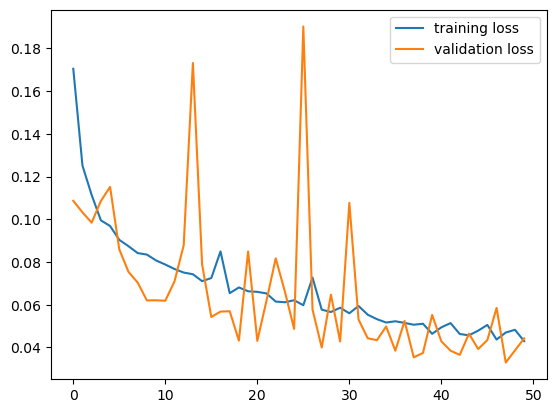

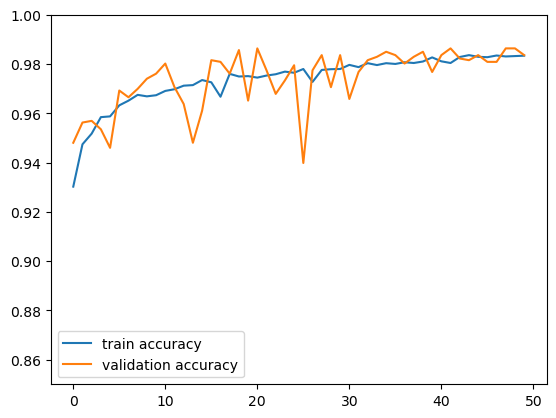

12/12 [==============================] - 0s 2ms/step - loss: 0.0859 - accuracy: 0.9726


loss: 0.08589395135641098 | train acc: 0.9726027250289917
12/12 [==============================] - 0s 2ms/step - loss: 0.0859 - accuracy: 0.9726


Before transfering: loss: 0.08589395135641098 | train acc: 0.9726027250289917



In [326]:
mlp_for_transfer = Sequential()
mlp_for_transfer.add(Dense(24, activation='tanh', input_dim=main_tr_d.shape[1]))
mlp_for_transfer.add(Dense(8, activation='tanh', input_dim=main_tr_d.shape[1]))
mlp_for_transfer.add(Dense(12, activation='tanh', input_dim=main_tr_d.shape[1]))
mlp_for_transfer.add(Dense(2, activation='softmax'))

mlp_for_transfer.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=0.4),  metrics=['accuracy'])

history_for_transfer = mlp_for_transfer.fit(main_tr_d, keras.utils.to_categorical(main_tr_l), epochs=50, validation_split=0.1, verbose=False)

plt.figure()
plt.plot(history_for_transfer.history['loss'], label='training loss')
plt.plot(history_for_transfer.history['val_loss'], label='test loss')
plt.legend(loc='best')

plt.figure()
plt.plot(history_for_transfer.history['accuracy'], label='train accuracy')
plt.plot(history_for_transfer.history['val_accuracy'], label='test accuracy')
plt.legend(loc='best')
plt.ylim([0.85,1])
plt.show()

score = mlp_for_transfer.evaluate(spe_te_d, keras.utils.to_categorical(spe_te_l))
print("\n\nloss: {} | train acc: {}".format(score[0], score[1]))

for i in range(len(mlp_for_transfer.layers)-1):
    mlp_for_transfer.layers[i].trainable = False
    
score = mlp_for_transfer.evaluate(spe_te_d, keras.utils.to_categorical(spe_te_l))
print("\n\nBefore transfering: loss: {} | train acc: {}\n".format(score[0], score[1]))

12/12 [==============================] - 0s 2ms/step - loss: 0.0675 - accuracy: 0.9726


loss: 0.06745050102472305 | train acc: 0.9726027250289917


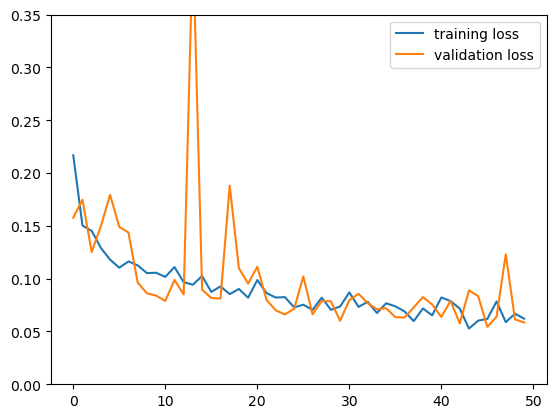

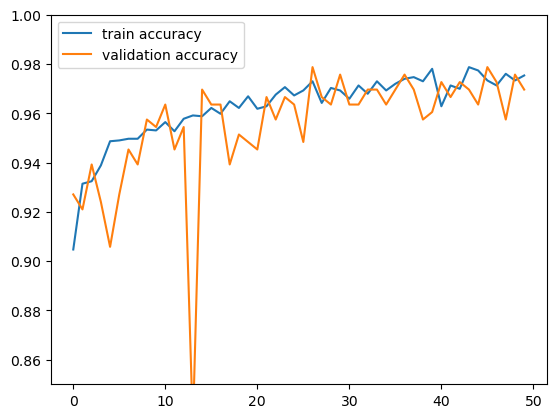

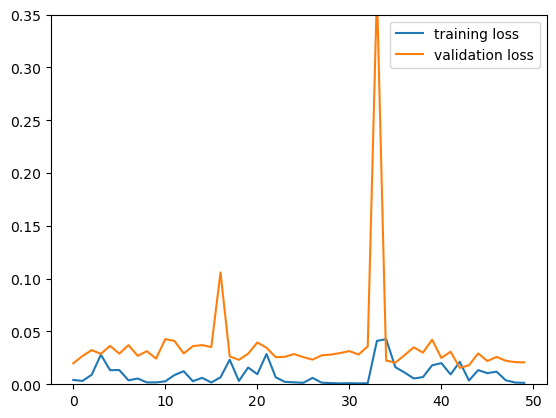

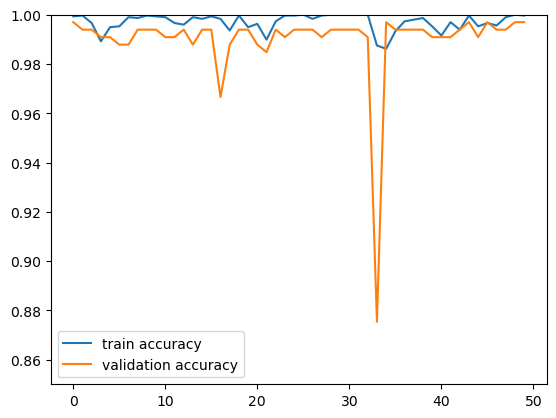

12/12 [==============================] - 0s 3ms/step - loss: 0.0505 - accuracy: 0.9918


loss: 0.05046766996383667 | train acc: 0.9917808175086975


In [324]:
mlp_straightforward = Sequential()
mlp_straightforward.add(Dense(24, activation='tanh', input_dim=spe_tr_d.shape[1]))
mlp_straightforward.add(Dense(8, activation='tanh', input_dim=spe_tr_d.shape[1]))
mlp_straightforward.add(Dense(12, activation='tanh', input_dim=spe_tr_d.shape[1]))
mlp_straightforward.add(Dense(2, activation='softmax'))

mlp_straightforward.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=0.4),  metrics=['accuracy'])

history_straightforward = mlp_straightforward.fit(spe_tr_d, keras.utils.to_categorical(spe_tr_l), epochs=50, validation_split=0.1, verbose=False)

plt.figure()
plt.plot(history_straightforward.history['loss'], label='training loss')
plt.plot(history_straightforward.history['val_loss'], label='test loss')
plt.legend(loc='best')
plt.ylim([0,0.35])

plt.figure()
plt.plot(history_straightforward.history['accuracy'], label='train accuracy')
plt.plot(history_straightforward.history['val_accuracy'], label='test accuracy')
plt.legend(loc='best')
plt.ylim([0.85,1])

score = mlp_straightforward.evaluate(spe_te_d, keras.utils.to_categorical(spe_te_l))
print("\n\nloss: {} | train acc: {}".format(score[0], score[1]))

history_transfer = mlp_for_transfer.fit(spe_tr_d, keras.utils.to_categorical(spe_tr_l), epochs=50, validation_split=0.1, verbose=False)

plt.figure()
plt.plot(history_transfer.history['loss'], label='training loss')
plt.plot(history_transfer.history['val_loss'], label='test loss')
plt.legend(loc='best')
plt.ylim([0,0.35])

plt.figure()
plt.plot(history_transfer.history['accuracy'], label='train accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='test accuracy')
plt.legend(loc='best')
plt.ylim([0.85,1])
plt.show()

score = mlp_for_transfer.evaluate(spe_te_d, keras.utils.to_categorical(spe_te_l))
print("\n\nloss: {} | train acc: {}".format(score[0], score[1]))

Clustering

In [364]:
def test(model, d, l):
    try:
        t_l = model.predict(d)
    except:
        t_l = model.fit_predict(d)
    eq = sum(l == t_l)/len(l)
    return max(eq, 1-eq)

In [522]:
# BUDAPEST
#tr_d, tr_l, te_d, te_l, _, _, _, _ = get_town_data([9,1,0], "BUDAPEST", 42)

# PERPIGNAN
tr_d, tr_l, te_d, te_l, _, _, _, _ = get_town_data([9,1,0], "PERPIGNAN", 42)

# DRESDEN
#tr_d, tr_l, te_d, te_l, _, _, _, _ = get_town_data([9,1,0], "DRESDEN", 42)

In [523]:
sum(np.zeros(len(te_l)) == te_l)/len(te_l)

0.5315068493150685

In [524]:
sum((np.random.random(len(te_l))>0.5) == te_l)/len(te_l)


0.5315068493150685

In [525]:
kmeans = cluster.KMeans(n_clusters=2, random_state=42, n_init="auto")
kmeans.fit(tr_d)
test(kmeans, te_d, te_l)

0.8383561643835616

In [526]:
spectral = cluster.SpectralClustering(n_clusters=2, random_state=42)
spectral.fit(tr_d)
test(spectral, te_d, te_l)

0.5123287671232877

In [527]:
agglomer = cluster.AgglomerativeClustering(n_clusters=2)
agglomer.fit(tr_d)
test(agglomer, te_d, te_l)

0.7972602739726027

In [528]:
gauss = mixture.GaussianMixture(n_components=2, covariance_type="spherical") #covariance_type = "spherical" should be better for 2 clusters in general
gauss.fit(tr_d)
test(gauss, te_d, te_l)

0.821917808219178

In [529]:
pca = PCA(n_components=2)
pca_d = pca.fit_transform(te_d)

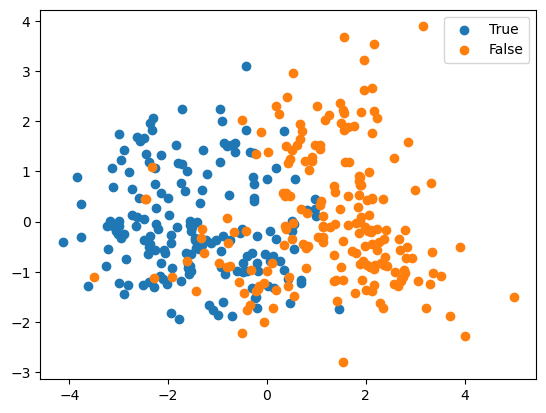

In [530]:
plt.figure()
plt.scatter(pca_d[te_l==1,0], pca_d[te_l==1,1], label='True')
plt.scatter(pca_d[te_l==0,0], pca_d[te_l==0,1], label='False')
plt.legend(loc='best')
plt.show()


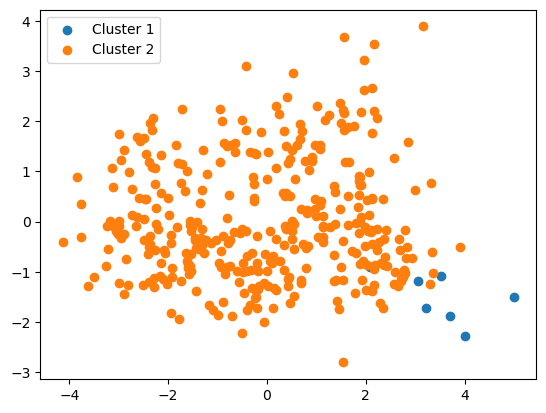

In [533]:
#model_lab = gauss.predict(te_d)
model_lab = spectral.fit_predict(te_d)
plt.figure()
plt.scatter(pca_d[model_lab==1,0], pca_d[model_lab==1,1], label='Cluster 1')
plt.scatter(pca_d[model_lab==0,0], pca_d[model_lab==0,1], label='Cluster 2')
plt.legend(loc='best')
plt.show()